In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
from skimage.transform import resize, rescale, rotate, setup, warp
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.patches as patches

from skimage.color import rgb2gray

import PIL
from PIL import Image

from google.colab import output

In [2]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

/content
Cloning into 'Lithuanian_OCR'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3540 (delta 0), reused 8 (delta 0), pack-reused 3531
Receiving objects: 100% (3540/3540), 109.28 MiB | 12.56 MiB/s, done.
Resolving deltas: 100% (577/577), done.


In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, hidden3_size)
        self.relu3 = nn.ReLU()      
        self.fc4 = nn.Linear(hidden3_size, hidden4_size)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden4_size, hidden5_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden5_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)
        out = self.fc3(out)        
        out = self.relu3(out)
        out = self.fc4(out)        
        out = self.relu4(out)
        out = self.fc5(out)        
        out = self.relu5(out)
        out = self.fc6(out)
        return out

In [0]:
network = Net(4096, 2500, 1500, 500, 100, 50, 3)
network.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/model.pth'))
network.eval()

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.6)
optimizer.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/optimizer.pth'))

criterion = nn.MSELoss()

In [0]:
def proccess_image(path):
  image = io.imread(path)
  image = rgb2gray(image)
  image = resize(image, (64, 64))
  
  return torch.tensor(image)

In [0]:
def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

In [0]:
def get_result(data):
  idx = get_max_from_tensor(data) - 1

  if(data[idx] > 0 and data[idx] < 1):
    return idx + 1
  # No object found
  elif(data[idx] <= 0):
    return 0
  # Best guess is that there is no object
  else:
    return 0

In [0]:
def find_in_array(arr, element):
  idx = 0
  found = []

  for el in arr:
    if(el == element):
      found.append(idx)
    idx += 1

  return found

In [0]:
def find_probability(output, idx):
  output = output.detach().numpy()
  probability = output[idx][0]
  for i in range(len(output)):
    if i != idx[0]:
      probability -= output[i]
  return probability

In [0]:
def prepare_image_for_network(image):
  image = resize(image, (64, 64))

  return image

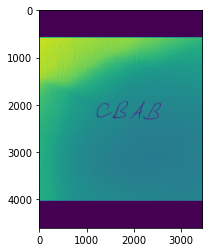

In [11]:
image = io.imread('/content/Lithuanian_OCR/Examples/example.jpg')

image = rotate(image, 90)
image = rgb2gray(image)
plt.imshow(image)

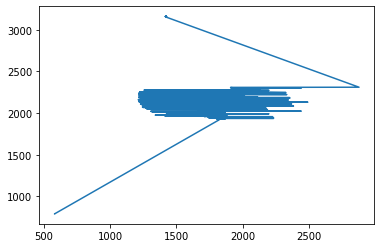

In [12]:
registered_x = []
registered_y = []

for y in range(image.shape[0]):
  last_val = image[y][0]
  for x in range(image.shape[1]):
    if(abs(last_val - image[y][x]) >= 0.1):
      registered_x.append(x)
      registered_y.append(y)
    last_val = image[y][x]

plt.plot(registered_x, registered_y, marker='o', markersize=0.0001)
print(len(registered_x))

In [0]:
class Letter():
  def __init__(self, element, start_x, end_x, start_y, end_y, prob):
    self.element = element
    self.start_x = start_x
    self.end_x = end_x
    self.start_y = start_y
    self.end_y = end_y
    self.prob = prob

In [20]:
step = 50
prob_reshold = 0.7

letters = []

for y in registered_y:
  for x in registered_x:
    found = False
    found_nx_end = 0
    found_y_end = 0
    found_prob = 0
    found_element = 0

    steps_x = (image.shape[1] - x)//step
    steps_y = (image.shape[0] - y)//step

    num_steps = steps_x
    if(steps_y < num_steps):
      num_steps = steps_y

    for i in range(num_steps):
      if(i != 0):
        cropped = image[x:x+i*step, y:y+i*step]
        output = network(torch.tensor(prepare_image_for_network(cropped)).flatten().float())

        res = get_result(output)
        if(res != 0):
          prob = find_probability(output, [res - 1])
          
          if(prob >= prob_reshold and prob > found_prob):
            found_x_end = x+i*step
            found_y_end = y+i*step
            found_element = res
            found_prob = prob
            found = True
    if(found == True):
      letters.append(Letter(found_element, x, found_x_end, y, found_y_end, found_prob))
      print("Found letter: {} with probability: {}".format(found_element, found_prob))

Found letter: 1 with probability: 0.9910116195678711
Found letter: 1 with probability: 0.9912108778953552
Found letter: 1 with probability: 0.9912108778953552
Found letter: 1 with probability: 0.9913833737373352
Found letter: 1 with probability: 0.7149312496185303
Found letter: 1 with probability: 0.7610897421836853
Found letter: 1 with probability: 0.7610897421836853
Found letter: 1 with probability: 0.7467532157897949
Found letter: 1 with probability: 0.9122279286384583
Found letter: 1 with probability: 0.7526193857192993
Found letter: 1 with probability: 0.7563894987106323
Found letter: 1 with probability: 0.9894207715988159
Found letter: 1 with probability: 0.9894207715988159
Found letter: 1 with probability: 0.7498722076416016
Found letter: 1 with probability: 0.7432652711868286
Found letter: 1 with probability: 0.7531716227531433
Found letter: 1 with probability: 0.7305101156234741
Found letter: 1 with probability: 0.7577019929885864
Found letter: 1 with probability: 0.7563894987

KeyboardInterrupt: ignored

In [0]:
print(len(letters))